# Original CvT-Model

<img src="./../CvT-Original.drawio.png?raw=1" alt="CvT-Modell mit Convolutional Embedding" title="CvT-Modell mit Convolutional Embedding" height="400" />

Dimensions sind ohne Batch-Size.

## Input-Dimensions

**Dimensions:** $H_0 = 64px, \quad W_0 = 64px, \quad C_0 = 3$ \
**Output-Shape:** `(3, 64, 64)`

## Conv2d

Berechnung Output-Dimensions:

$ \text{kernel size}\ k = 7, \quad \text{stride}\ s = 4, \quad \text{padding}\ p = 3 $ \
$ H_i = \frac{H_{i-1} + 2p - k}{s}\ + 1, \quad W_i = \frac{W_{i-1} + 2p - k}{s}\ + 1 $

**Output-Dimensions:** $H_1 = 16px, \quad W_1 = 16px, \quad C_1 = 64$ \
**Output-Shape:** `(64, 16, 16)`

## Flatten

**Output-Dimensions:** $H_1 W_1 \times C_1 = 16*16 \times 64$ \
**Output-Shape:** `(256, 64)`

## Conv Projection



## Multi-Head Attention

Berechnung der Query-, Key- und Value-Matrizen:

$X \in \mathbb{R}^{H_1 W_1 \times C_1}$ \
$d_k$ ist die Dimension der Value-, Query- und Key-Vektoren \
$W^Q, W^K, W^V \in \mathbb{R}^{C_1 \times d_k}$ \
$Q = XW^Q, \quad K = XW^K, \quad V = XW^V$

$d_k = 64$ \
$Q, K, V \in \mathbb{R}^{256 \times 64}$

**Output-Dimensions:** $256 \times 64$ \
**Output-Shape:** `(256, 64)`

## MLP

Expansion factor: $e = 4$

1. **Step:** Linear ➔ GELU ➔ Dropout
   
   **Output-Dimensions:** $256 \times 64 \times 4 = 256 \times 256$ \
   **Output-Shape:** `(256, 256)`

2. **Step:** Linear ➔ Dropout

    **Output-Dimensions:** $256 \times 256 \times 64 = 256 \times 64$ \
    **Output-Shape:** `(256, 64)`


# Imports

In [1]:
%pip install pytorch-lightning
%pip install torch torchvision
%pip install lightning
%pip install einops
%pip install dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import torch
from einops import rearrange
import torch.nn as nn

IS_PAPERSPACE = os.getcwd().startswith('/notebooks')
dir_env = os.path.join(os.getcwd(), '.env') if IS_PAPERSPACE else os.path.join(os.getcwd(), '..', '.env')
_ = load_dotenv(dotenv_path=dir_env)

# Modell

In [3]:
class ConvEmbed(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size // 2)
        self.norm = nn.LayerNorm(out_channels)

    def forward(self, x):
        x = self.proj(x)  # B x C x H x W
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # B x (H*W) x C
        x = self.norm(x)
        return x, H, W

class DWConv(nn.Module):
    def __init__(self, dim, kernel_size=3):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=kernel_size, padding=kernel_size // 2, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).reshape(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class ConvAttention(nn.Module):
    def __init__(self, dim, heads=4, kernel_size=3):
        super().__init__()
        self.num_heads = heads
        self.head_dim = dim // heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.dwconv = DWConv(dim, kernel_size)

        self.attn_drop = nn.Dropout(0.1)
        self.proj_drop = nn.Dropout(0.1)

    def forward(self, x, H, W):
        B, N, C = x.shape
        qkv = self.qkv(self.dwconv(x, H, W)).reshape(B, N, 3, self.num_heads, self.head_dim)
        q, k, v = qkv.unbind(2)  # each: B, N, heads, head_dim

        q = q.transpose(1, 2)  # B, heads, N, head_dim
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        return self.proj_drop(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4.0, drop_path=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = ConvAttention(dim, heads)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(0.2),  # Adding dropout here
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x, H, W):
        x = x + self.attn(self.norm1(x), H, W)
        x = x + self.mlp(self.norm2(x))
        return x

class CvTStage(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, depth, heads):
        super().__init__()
        self.embed = ConvEmbed(in_ch, out_ch, kernel_size, stride)
        self.blocks = nn.ModuleList([
            TransformerBlock(out_ch, heads) for _ in range(depth)
        ])

    def forward(self, x):
        x, H, W = self.embed(x)
        for blk in self.blocks:
            x = blk(x, H, W)
        return x, H, W

class CvTOriginal(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.num_classes = num_classes
        self.stage1 = CvTStage(3, 64, kernel_size=7, stride=4, depth=1, heads=1)
        self.stage2 = CvTStage(64, 192, kernel_size=3, stride=2, depth=2, heads=3)
        self.stage3 = CvTStage(192, 384, kernel_size=3, stride=2, depth=12, heads=6)

        self.head = nn.Sequential(
            nn.LayerNorm(384),
            nn.Linear(384, num_classes)
        )

    def forward(self, x):
        x1, H1, W1 = self.stage1(x)
        x1_spatial = rearrange(x1, 'b (h w) c -> b c h w', h=H1, w=W1)

        x2, H2, W2 = self.stage2(x1_spatial)
        x2_spatial = rearrange(x2, 'b (h w) c -> b c h w', h=H2, w=W2)

        x3, _, _ = self.stage3(x2_spatial)
        x = x3.mean(dim=1)
        return self.head(x)

## Testing

In [4]:
model = CvTOriginal()

dummy_input = torch.randn(8, 3, 64, 64)
output = model(dummy_input)

assert output.shape == (8, 200), f"Expected output shape (8, 200), but got {output.shape}"
print("Model output shape is as expected:", output.shape)

dummy_input = torch.randn(64, 3, 64, 64)
output = model(dummy_input)

assert output.shape == (64, 200), f"Expected output shape (64, 200), but got {output.shape}"
print("Model output shape is as expected:", output.shape)


Model output shape is as expected: torch.Size([8, 200])
Model output shape is as expected: torch.Size([64, 200])


# Dataset

In [5]:
from models.processData import prepare_data_and_get_loaders

train_loader, val_loader, test_loader = prepare_data_and_get_loaders("/datasets/tiny-imagenet-200/tiny-imagenet-200.zip", "data/tiny-imagenet-200")

Data already extracted.


### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


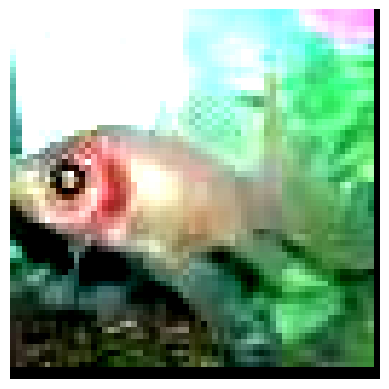

In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

image, label = train_loader.dataset[0]
imshow(image)

# Training

In [7]:
from models.trainModel import train_test_model

train_test_model(model, train_loader, val_loader, test_loader)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: seya-schmassmann-fhnw (wods). Use `wandb login --relogin` to force relogin


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CvTOriginal        | 23.1 M | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | train_f1  | MulticlassF1Score  | 0      | train
4 | val_acc   | MulticlassAccuracy | 0      | train
5 | val_f1    | MulticlassF1Score  | 0      | train
6 | test_acc  | MulticlassAccuracy | 0      | train
7 | test_f1   | MulticlassF1Score  | 0      | train
---------------------------------------------------------
23.1 M    Trainable params
0         Non-trainable params
23.1 M    Total params
92.588    Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4359999895095825
         test_f1            0.4267636239528656
        test_loss            3.254619836807251
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇█████████████
train_f1,▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇█████████████
train_loss,█▇▇▆▆▅▅▄▄▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▃▄▅▆▆▇▇██████████████████████
val_f1,▁▃▅▅▆▆▇▇██████████████████████
val_loss,█▅▄▃▂▂▂▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂
